In [14]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

# Contents:
* [Data Setup](#Data-Setup)
* [Create AOI and Parameters](#Create-AOI-and-Parameters)
* [Airfield Objective](#Airfield-Objective)
 * [Site Suitability](#Site-Suitability)
 * [Site Configuration](#Site-Configuration)
 * [Site Evaluation](#Site-Evaluation)
* [Site Relations](#Site-Relations)

# Data Setup

In [15]:
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"

# Create AOI and Parameters

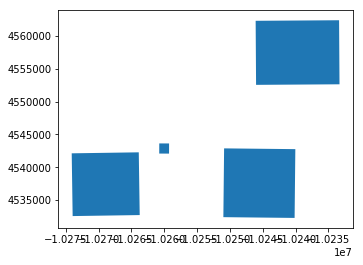

In [4]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()

# Airfield Objective

## Site Suitability

In [17]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)

Generated 12161 squares in 0 seconds


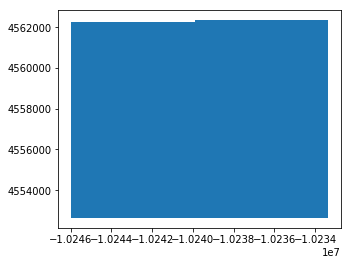

In [18]:
airfieldEvaluationDataFrame.plot()

In [19]:
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)


Text(0.5,0.98,u'Zonal Calculation of Slope over AOI')

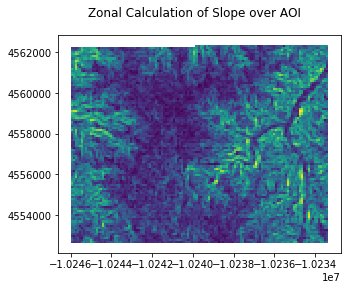

In [20]:
airfieldSlopeEvaluationDataFrame.plot(column='max')
plt.suptitle("Zonal Calculation of Slope over AOI")

Text(0,0.5,u'Fraction of AOI Evaluation Grid')

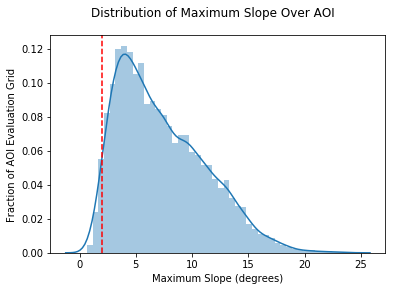

In [21]:
sns.distplot(airfieldSlopeEvaluationDataFrame['max'])
plt.axvline(2, color='red', linestyle='--')
plt.suptitle("Distribution of Maximum Slope Over AOI")
plt.xlabel("Maximum Slope (degrees)")
plt.ylabel("Fraction of AOI Evaluation Grid")

**Subset by maximum slope < 2**

In [22]:
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
print "Subset consists of %s areas, reduced from the original %s areas" %(len(airfieldSlopeEvaluationDataFrameSubset.index),len(airfieldSlopeEvaluationDataFrame.index))

Subset consists of 364 areas, reduced from the original 12161 areas


Text(0.5,0.98,u'New Evaluation Areas')

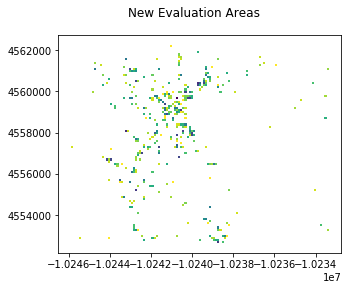

In [23]:
airfieldSlopeEvaluationDataFrameSubset.plot(column='max')
plt.suptitle("New Evaluation Areas")

**Create Larger Candidate Sites Using the Simplified Approach**

## Site Configuration

In [24]:
largerPolygonDimension = 800
largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, largerPolygonDimension)

Text(0.5,0.98,u'Site Configuration for Airfield')

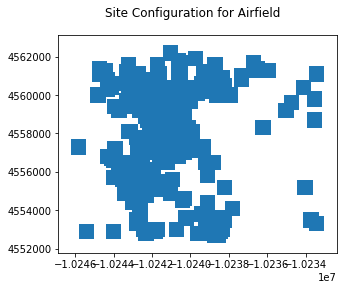

In [26]:
largerAirfields.plot()
plt.suptitle("Site Configuration for Airfield")

## Site Evaluation

**Calculate Cut Fill For Objective Function**

In [27]:
cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=1)

Text(0.5,0.98,u'Cut Fill Required for Candidate Airfields')

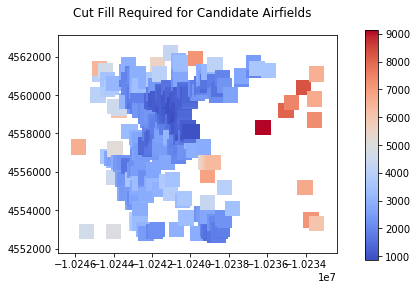

In [29]:
vmin = min(cutFillDF['totalCutFillVolume'])
vmax = max(cutFillDF['totalCutFillVolume'])
ax = cutFillDF.plot(column='totalCutFillVolume', cmap='coolwarm', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Cut Fill Required for Candidate Airfields")

Text(0,0.5,u'Fraction of Candidate Sites')

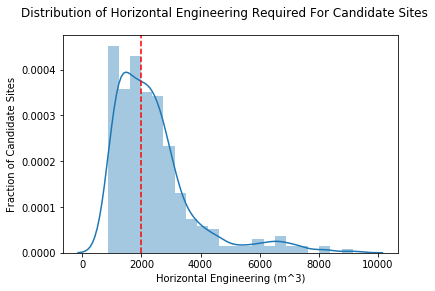

In [30]:
sns.distplot(cutFillDF['totalCutFillVolume'])
plt.axvline(2000, color='red', linestyle='--')
plt.suptitle("Distribution of Horizontal Engineering Required For Candidate Sites")
plt.xlabel("Horizontal Engineering (m^3)")
plt.ylabel("Fraction of Candidate Sites")

**Distance to linear features**

# Camp 1 Objective

In [18]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

Generated 9551 squares in 0 seconds


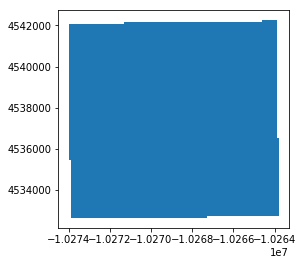

In [19]:
baseObjective1EvaluationDataFrame.plot()

# Camp 2 Objective

In [20]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

Generated 11141 squares in 0 seconds


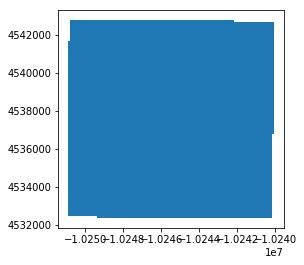

In [21]:
baseObjective2EvaluationDataFrame.plot()

In [16]:
m = io.Map()
m.test_addTimeSeriesHeatMap()
m.map

# Site Relations